In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 1. Loading the Data
I loaded up the `Train_data.csv` dataset

In [23]:
train_df = pd.read_csv('Train_data.csv')
train_df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


# 2. Data Cleaning & Preprocessing
Here, I'm cleanimg `NumberOfWindows` - this converts string ranges and dots to numbers

I noticed `NumberOfWindows` was being read as a string due to some `>=10` entries and placeholders like `.`. I cleaned these up by converting them to numeric values and handling the missing pieces. This way, the model can actually understand the relationship between the number of windows and the likelihood of a claim.

In [6]:
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].str.strip()
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].replace('>=10', '10')
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].replace('.', np.nan)
train_df['NumberOfWindows'] = pd.to_numeric(train_df['NumberOfWindows'], errors='coerce')

I also dropped `Customer Id`, since a random ID number won't help the model predict insurance risk. By transforming these into clean, numeric features, I’m ensuring the model can actually understand the patterns in the data."

In [7]:
train_df = train_df.drop('Customer Id', axis=1)

Next, I imputed the Missing Values

I didn't want to just delete rows with missing data and lose valuable information. Instead, I filled in the blanks using the median for numbers (to stay safe from extreme outliers) and the mode for categories like `Garden`. It’s a simple but effective way to keep the dataset whole without accidentally biasing my results with "empty" entries

In [8]:
train_df['Building Dimension'] = train_df['Building Dimension'].fillna(train_df['Building Dimension'].median())
train_df['Date_of_Occupancy'] = train_df['Date_of_Occupancy'].fillna(train_df['Date_of_Occupancy'].median())
train_df['NumberOfWindows'] = train_df['NumberOfWindows'].fillna(train_df['NumberOfWindows'].median())
train_df['Garden'] = train_df['Garden'].fillna(train_df['Garden'].mode()[0])
train_df['Geo_Code'] = train_df['Geo_Code'].fillna(train_df['Geo_Code'].mode()[0])

# 3. Exploratory Data Analysis (Visuals)
Before jumping into the math, I wanted to see what the data actually looks like. I set up the plot style, and plotted a few charts to check for class imbalances and used a heatmap to see which features were 'talking' to each other. Seeing the distribution of building sizes vs. claims really helped confirm my hunch that larger properties tend to carry higher insurance risks

In [9]:
sns.set(style="whitegrid")

###Visual 1: Target Variable Distribution

/tmp/ipython-input-69449509.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Claim', data=train_df, palette='Set2')


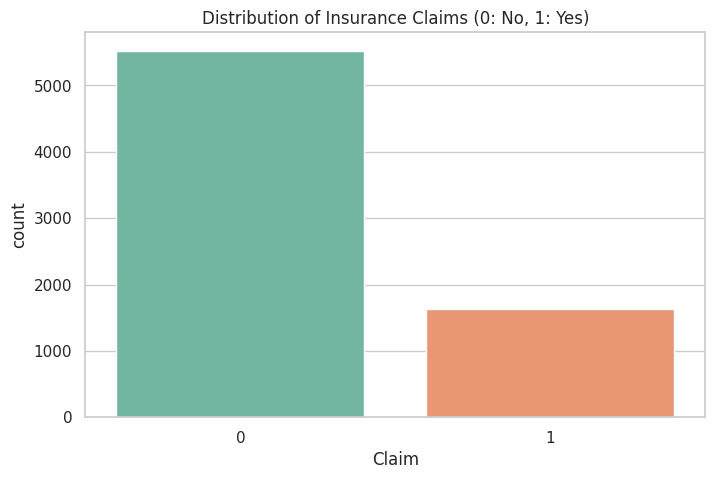

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Claim', data=train_df, palette='Set2')
plt.title('Distribution of Insurance Claims (0: No, 1: Yes)')
plt.savefig('target_distribution.png')
plt.show()

###Visual 2: Building Dimension vs Claims

/tmp/ipython-input-2227508382.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Claim', y='Building Dimension', data=train_df, palette='Set1')


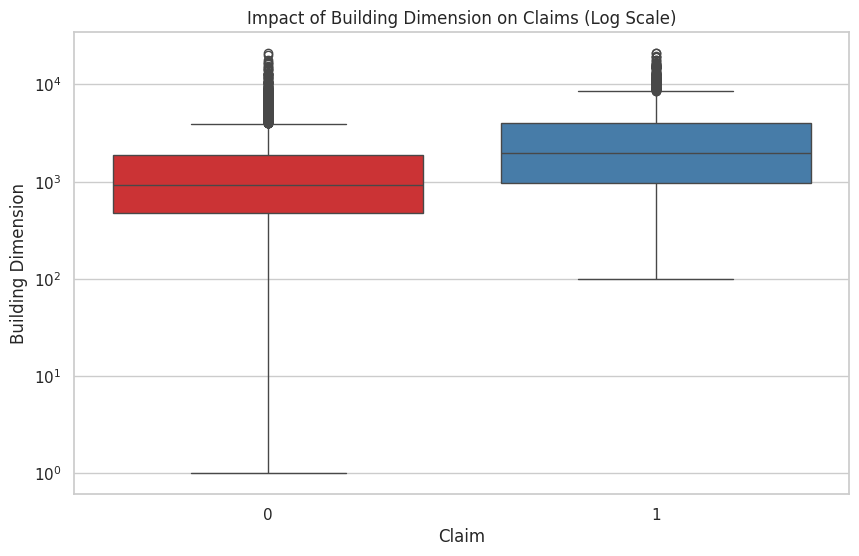

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Claim', y='Building Dimension', data=train_df, palette='Set1')
plt.yscale('log')  # Log scale used due to wide range of sizes
plt.title('Impact of Building Dimension on Claims (Log Scale)')
plt.savefig('dimension_vs_claim.png')
plt.show()

###Visual 3: Correlation Heatmap

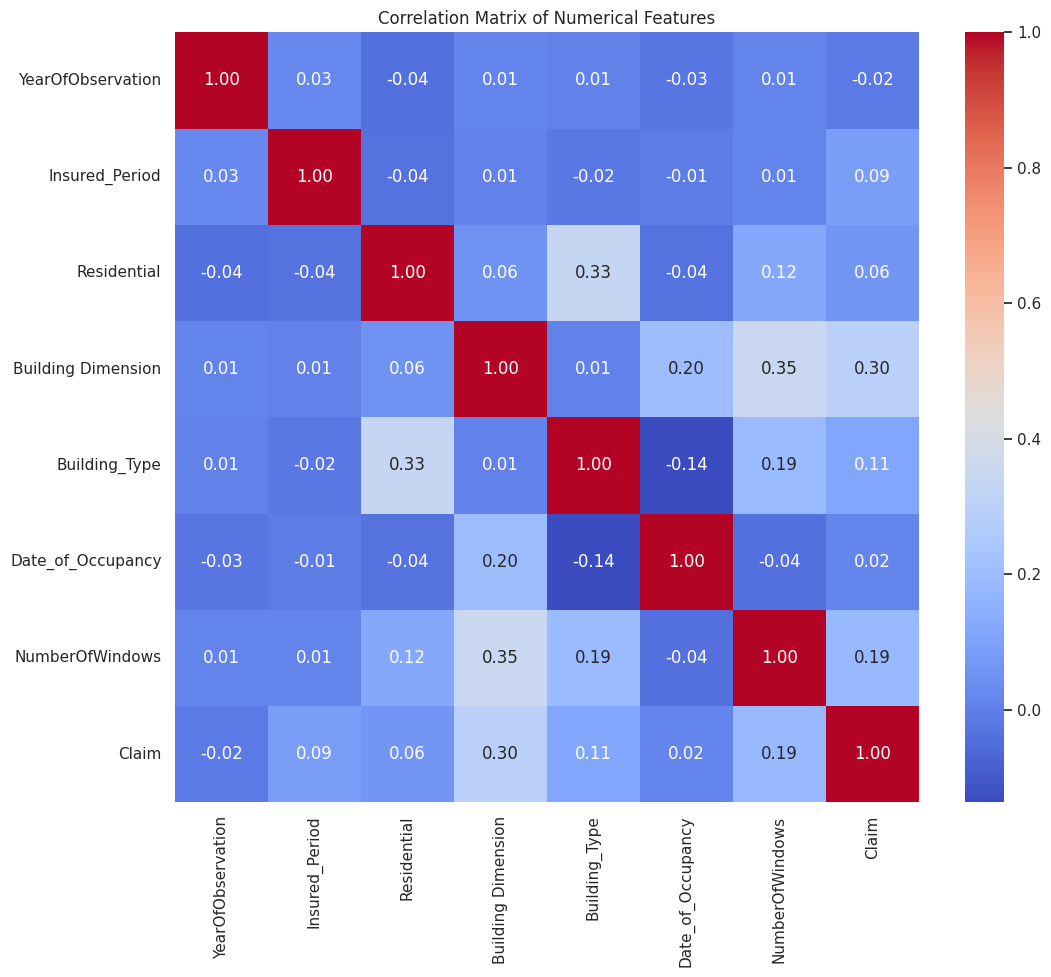

In [12]:
plt.figure(figsize=(12, 10))
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
sns.heatmap(train_df[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.savefig('correlation_matrix.png')
plt.show()

###Visual 4: Settlement Type and Claims

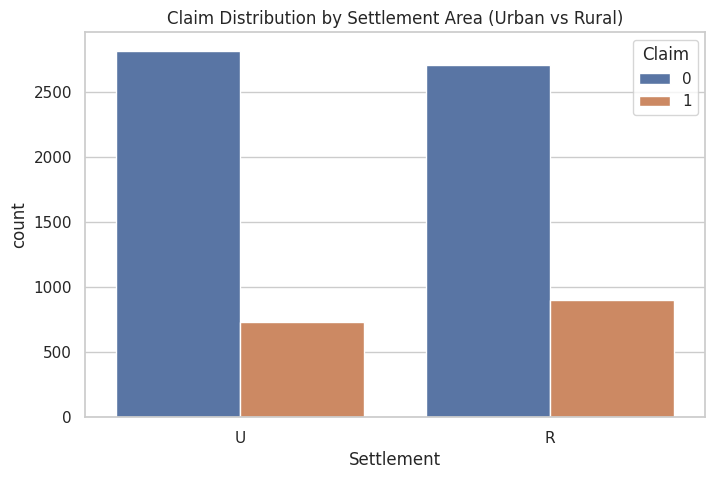

In [13]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Settlement', hue='Claim', data=train_df)
plt.title('Claim Distribution by Settlement Area (Urban vs Rural)')
plt.savefig('settlement_eda.png')
plt.show()

# 4. Modeling Preprocessing
I first encoded the categorical variables

Machine learning models don't speak 'English,' so I used `LabelEncoder` to turn categorical text into numbers they can process. When splitting the data into training and testing sets, I used stratification. This makes sure that the small percentage of actual claims is represented equally in both sets, preventing the model from getting a skewed view of reality

In [14]:
le = LabelEncoder()
cat_cols = ['Building_Painted', 'Building_Fenced', 'Garden', 'Settlement', 'Geo_Code']
for col in cat_cols:
    train_df[col] = le.fit_transform(train_df[col].astype(str))

Here, I'm defining the features and targets

In [15]:
X = train_df.drop('Claim', axis=1)
y = train_df['Claim']

Then here, I'm splitting, using stratification to maintain claim ratio in training/testing

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Here, I scaled the data for Logistic Regression

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. Model Implementation
I decided to run three different models to see which one handled the data best: Logistic Regression (my baseline), Random Forest, and Gradient Boosting. Since we have more 'no-claim' cases than 'claims,' I focused on the ROC-AUC score rather than just accuracy. It’s a much fairer way to measure how well the model distinguishes between a building that will file a claim and one that won't.

###Model A: Logistic Regression (Balanced weights)

In [18]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]

###Model B: Random Forest

In [19]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]

###Model C: Gradient Boosting

In [20]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
gbc.fit(X_train, y_train)
gbc_probs = gbc.predict_proba(X_test)[:, 1]

# 6. Evaluation & Final Data Visuals
To wrap things up, I looked at which features the model relied on most. It turns out that `Building Dimension` and `Geo_Code` are the biggest drivers of claims. This is a great takeaway—it tells us that where a building is and how big it is are the most critical factors for an insurance provider to watch."

In [21]:
print(f"Logistic Regression ROC-AUC: {roc_auc_score(y_test, lr_probs):.4f}")
print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, rf_probs):.4f}")
print(f"Gradient Boosting ROC-AUC: {roc_auc_score(y_test, gbc_probs):.4f}")

Logistic Regression ROC-AUC: 0.6860
Random Forest ROC-AUC: 0.6718
Gradient Boosting ROC-AUC: 0.6953


###Visual 5: Feature Importance (From Random Forest)


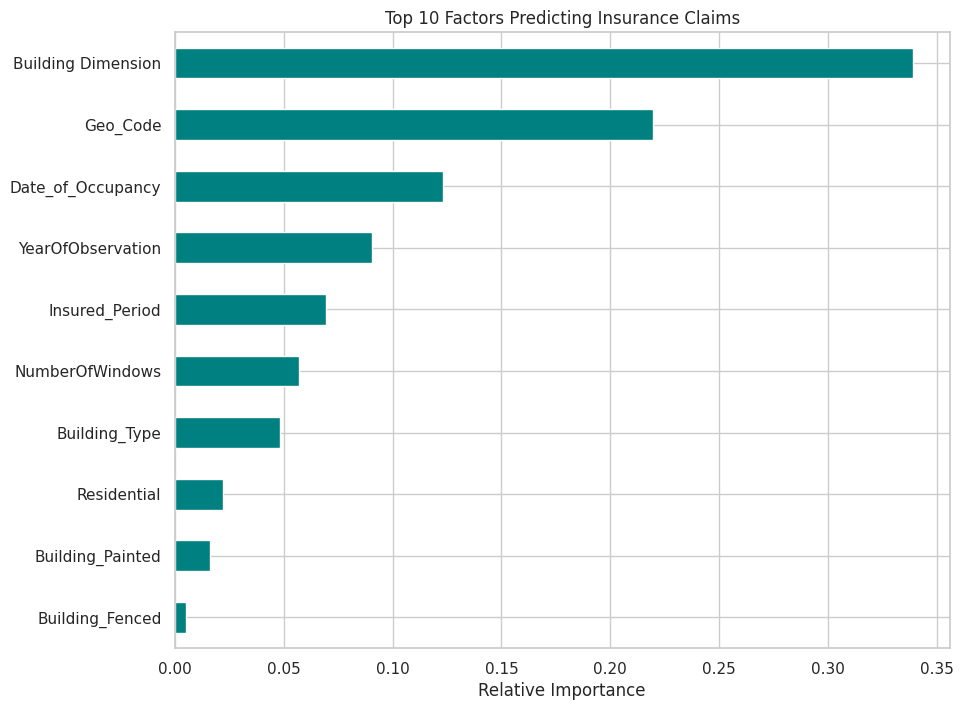

In [22]:
plt.figure(figsize=(10, 8))
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='teal')
plt.title('Top 10 Factors Predicting Insurance Claims')
plt.xlabel('Relative Importance')
plt.savefig('feature_importance.png')
plt.show()